# Lab Outline

## Online

#### This document
<font color="#f22" >
You can find the most up-to-date version of this document online as 
<br/>
- an [HTML file](https://cdn.rawgit.com/mjbright/jupyter_notebooks/master/2016-Feb_Docker_Build_Lab/2016-Feb_Docker_Build_Lab.html) (http://bit.ly/1T0118e) or as
<br/>
- a [PDF file](https://raw.githubusercontent.com/mjbright/jupyter_notebooks/master/2016-Feb_Docker_Build_Lab/2016-Feb_Docker_Build_Lab.pdf) (http://bit.ly/1QF0XaH)  or as
<br/>
- a [Jupyter](http://www.jupyter.org) notebook at [2016-Feb_Docker_Build_Lab](https://github.com/mjbright/jupyter_notebooks/blob/master/2016-Feb_Docker_Build_Lab/).
</font>

This notebook is runnable in a Jupyter installation with the bash_kernel installed.

Although that is not the subject of this lab, if you want to create your own environment in which to run this lab with Docker components already installed (and even Jupyter/bash_kernel), refer to the README.md [here](https://github.com/mjbright/jupyter_notebooks/blob/master/2016-Feb_Docker_Build_Lab/)

<br/><br/><br/>
<center><font size=-1 color="#77f">
    <i class="fa-linkedin fa-2x fa"> [mjbright](https://www.linkedin.com/in/mjbright)</i>,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    <i class="fa-github fa-2x fa"> [mjbright](https://github.com/mjbright)</i>,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    <i class="fa-twitter fa-2x fa">[@mjbright](http://twitter.com/mjbright)</i>,
</font></center>


<a name="TOP"></a>
## Lab-Description
[TOP](#TOP)


We first need to recuperate the source code examples:

<font color="#f22">
### Lab Start
</font>
Start this lab by first performing the below step:

In [ ]:
## Lab Start:

rm -rf ~/src

git clone https://github.com/mjbright/docker-examples src

./src/START_LAB.sh

Then procede with the following sections:

- [1. Introduction](#intro)
- [2. Basic Docker Builds](#builds)
- [3. Creating Small Images](#small-images)
  - [Creating a small binary with C](#small-c)
  - [Creating a small binary with Go](#small-go)
  - [Creating a toolset Docker image containing several executables](#small-push)
  
- [4. Pushing our image to Docker Hub](#small-multi)
  
- [5. Dockerfile best practices](#build-best-practices)

- [6. Using the official 'Language Stack' images](#lang-stacks)
  - [Using a Language Stack (Node.js)](#medium-node)
  - [Using a Language Stack (Python)](#medium-python)
  
- [7. Using Compose](#compose)
  - [Building complex systems with Compose](#Compose)
  - [Rails example with Compose](#Rails-Example-with-Compose)
  
- [8. Building Docker](#building-docker)
  - [Building Docker with Docker](#Building-Docker-with-Docker)

[References](#References)

<hr/>
  
### Overall description of the lab steps

**NOTE: All lab steps can be considered optional, attendees may perform them in order, or jump to the section of interest to them (to get to the more complicated steps)**


<a name="1.intro" />
# Introduction
## A refresh on Docker concepts

You may want to skip this section if you have already run the introductory lab.

Look at what docker version you are running.
Note that the 'docker version' command reports the local client version as well as the server (docker engine) version.

In [1]:
docker version

Client:
 Version:      1.10.0-rc2
 API version:  1.22
 Go version:   go1.5.3
 Git commit:   c1cdc6e
 Built:        Wed Jan 27 21:06:37 2016
 OS/Arch:      linux/amd64

Server:
 Version:      1.10.0-rc2
 API version:  1.22
 Go version:   go1.5.3
 Git commit:   c1cdc6e
 Built:        Wed Jan 27 21:06:37 2016
 OS/Arch:      linux/amd64


### Images are image layers

Remember that when we talk of a container image it is really a collection of image layers.

The docker info command provides information about the docker engine, see below.

In [2]:
docker info

Containers: 7
 Running: 0
 Paused: 0
 Stopped: 7
Images: 100
Server Version: 1.10.0-rc2
Storage Driver: devicemapper
 Pool Name: docker-253:1-74951993-pool
 Pool Blocksize: 65.54 kB
 Base Device Size: 10.74 GB
 Backing Filesystem: ext4
 Data file: /dev/loop0
 Metadata file: /dev/loop1
 Data Space Used: 5.237 GB
 Data Space Total: 107.4 GB
 Data Space Available: 31.46 GB
 Metadata Space Used: 7.438 MB
 Metadata Space Total: 2.147 GB
 Metadata Space Available: 2.14 GB
 Udev Sync Supported: false
 Deferred Removal Enabled: false
 Deferred Deletion Enabled: false
 Deferred Deleted Device Count: 0
 Data loop file: /var/lib/docker/devicemapper/devicemapper/data
 Metadata loop file: /var/lib/docker/devicemapper/devicemapper/metadata
 Library Version: 1.02.82 (2013-10-04)
Execution Driver: native-0.2
Logging Driver: json-file
Plugins: 
 Volume: local
 Network: bridge null host
Kernel Version: 3.10.0-229.4.2.el7.x86_64
Operating System: Red Hat Enterprise Linux
OSType: linux
Architecture: x86_6

But if we look at the number of containers and images, the number of images it is not the same as provided above.
Why do you think that is?

First let's list the number of running and number of stopped containers

**NOTE: the value on your system will be different**

In [13]:
# Show the running containers:
docker ps

# Count the number of running containers:
echo
echo "Total number of running containers:"
docker ps | tail -n +2 | wc -l

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES

Total number of running containers:
0


In [14]:
# Show all the containers (running or stopped):
docker ps -a

# Count all the containers (running or stopped):
echo
echo "Total number of containers (running or stopped):"
docker ps -a | tail -n +2 | wc -l # Number of stopped and running containers ('tail -n +2' excludes the header line)

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES

Total number of containers (running or stopped):
0


We can see that the number of containers reported by docker info correctly reports the number of total containers, running or not

But listing images gives a different value from the 'docker info' value

In [16]:
# Show the images:
docker images

# Count the images:
echo
echo "Total number of images:"
docker images | tail -n +2 | wc -l

REPOSITORY              TAG                 IMAGE ID            CREATED             SIZE
lab/basic               latest              f208d8b26538        2 hours ago         689.1 MB
dockercomposedemo_web   latest              e0660b1f2253        7 hours ago         683 MB
test/flask_app          latest              055715f44c31        7 hours ago         683 MB
compose_weba            latest              270de0754a23        18 hours ago        645.8 MB
compose_webb            latest              270de0754a23        18 hours ago        645.8 MB
compose_webc            latest              270de0754a23        18 hours ago        645.8 MB
node-hello              latest              446ed2410baf        19 hours ago        645.8 MB
lab/go-hello            latest              2efe3ea09cbf        19 hours ago        2.367 MB
lab/toolset             latest              f63a40539224        20 hours ago        878.1 kB
dockerlabs/toolset      userN               8f1514534590        20 hours ago  

That is because there are many intermediate image layers which are not normally listed.
But we can list those layers using the '-a' option and now we see a number close to the value from 'docker info'.

(We will see later how the 'docker history' command allows us to see how the layers were created).

In [17]:
# Show all the image layers:
docker images -a

# Count all the image layers:
echo
echo "Total number of image layers:"

docker images -a | tail -n +2 | wc -l  # The number of image layers+1 (inc. header line)

REPOSITORY              TAG                 IMAGE ID            CREATED             SIZE
lab/basic               latest              f208d8b26538        2 hours ago         689.1 MB
<none>                  <none>              336f43130041        2 hours ago         689.1 MB
<none>                  <none>              562809286a88        2 hours ago         689.1 MB
dockercomposedemo_web   latest              e0660b1f2253        7 hours ago         683 MB
<none>                  <none>              6e1b1956bb02        7 hours ago         682.9 MB
<none>                  <none>              d775fdb51560        7 hours ago         683 MB
<none>                  <none>              0551a74b587c        7 hours ago         676.1 MB
test/flask_app          latest              055715f44c31        7 hours ago         683 MB
<none>                  <none>              16d1bc9bb7eb        7 hours ago         683 MB
<none>                  <none>              dfab1ec00524        7 hours ago       

Images can include 1 static binary file or more and can even include a whole distribution.
Launching a container launches a single process within that container - which may in turn span other child processes.

Let us look at an extremely small image to have an idea just how small an executable image can be.
Docker provide an official 'hello-world' image which simply echoes some output to the console.

Let's run that image to see and then investigate the image.
First let's search for the image; we see that the first image is 'hello-world' which is an official build

In [18]:
docker search hello-world

NAME                                     DESCRIPTION                                     STARS     OFFICIAL   AUTOMATED
hello-world                              Hello World! (an example of minimal Docker...   47        [OK]       
tutum/hello-world                        Image to test docker deployments. Has Apac...   19                   [OK]
marcells/aspnet-hello-world              ASP.NET vNext - Hello World                     2                    [OK]
bonomat/nodejs-hello-world               a simple nodejs hello world container           1                    [OK]
carinamarina/hello-world-app             This is a sample Python web application, r...   1                    [OK]
carinamarina/hello-world-web             A Python web app, running on port 5000, wh...   1                    [OK]
vegasbrianc/docker-hello-world                                                           1                    [OK]
mikelh/hello-world                       simplified hello world as dummy start 

Let's now run that image

In [23]:
docker run hello-world

# Note how we see the pulling of the image if not already available locally:


Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://docs.docker.com/userguide/



If it took a while to run, this was due to the time needed to download the image before running it - see above.

Try the command a second time to see how it runs instantaneously as there is no need to download the image which already exists locally on the 'docker engine'.

In [24]:
docker run hello-world

# The second time there is no need to repull the image:


Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://docs.docker.com/userguide/



Let us inspect the image.  We see that the file is only 960 bytes large, it must be machine code to print out the text.  So we see that an image can be really very small

In [25]:
docker images hello-world

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
hello-world         latest              690ed74de00f        3 months ago        960 B


We can also inspect the image with the history command to see how it was constructed.

Note that history shows the image layers in reverse order, latest first.

From the below command we can see that the image was created from only 2 image layers.

The image was built simply by copying in a binary executable and then specifying the default command to invoke when the image is run.

In [27]:
docker history hello-world

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
690ed74de00f        3 months ago        /bin/sh -c #(nop) CMD ["/hello"]                0 B                 
<missing>           3 months ago        /bin/sh -c #(nop) COPY file:1ad52e3eaf4327c8f   960 B               


In [29]:
echo
echo "Total size (in bytes) of text in 'hello-world' image:"
docker run hello-world | wc -c


Total size (in bytes) of text in 'hello-world' image:
801


So we see that 801 bytes of that executable is the actual text printed !
So the real program size is roughly 160 bytes (of assembler no doubt)

<a name="builds" />
## Basic Docker Builds
[TOP](#TOP)

#### Dockerfile

Images are built from Dockerfiles which contain a series of commands used to build up a docker image.
Note that each command in the Dockerfile results in a new image layer being created, no matter how trivial the command - even ENV "commands" create a new image layer.

In the following lab we will see how images can be built systematically from a Dockerfile using the 'docker build' command.

#### DockerHub

When we pull an image we pull it from a Docker Registry.  The [DockerHub](https://hub.docker.com/) is a free to use Docker registry allowing to store your own image files (which are publicly available unless you pay for your account) and to pull other image files of other users or officially provided images.

You can create images either by
- building them from a Dockerfile (thus in a **repeatable** manner)
- building them manually by modifying a running container and *'commit'*ing it's state

The DockerHub contains images which may be
- **Automated builds** (built from a git repository)
  - Such builds are usually built from an open-source git repo and so are called **Trusted builds** because the source code is available.
    *Note:* The github repo may contain binary files though
- **Official builds** are builds which are builds provided by partners or by Docker themselves

Other images may exist in the hub but their origin is unknown and so represent a security risk.

It is possible to search the DockerHub, or another Docker Registry, using the 'docker search' command with appropriate options.  Other companies offer their own Docker Registry which may be freely accessible e.g. RedHat, internal to a company e.g. HPE IT, or available as part of a paid for service e.g. IBM or Amawon Web Services ECR.


In [36]:
mkdir -p ~/test
cd    ~/test

cat > Dockerfile.basic <<EOF
#
# Dockerfile to demonstrate the simplest build
#
FROM python

MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

# NOTE: all RUN commands are executed at build time,
#       look at the output of the "docker build" below and you will see the Python version.
RUN python --version

CMD bash

EOF

In [2]:
ls -altr Dockerfile.basic

ls: cannot access Dockerfile.basic: No such file or directory


We can now build a new image using this dockerfile using the below command where
- we explicitly select the *Dockerfile.basic* which we just created with

    **-f Dockerfile.basic**
    
- we specify the current directory as the context for the build (any ADD/COPY or Dockerfile files will be sourced from here) with

    **.**


- we specify the specific tag to use for the generated image as "*lab/basic*" with

    **-t lab/basic**


In [52]:
docker build -f Dockerfile.basic -t lab/basic . 

unable to prepare context: unable to evaluate symlinks in Dockerfile path: lstat /vagrant/src/createTinyC/Dockerfile.basic: no such file or directory


Note that during the build, the RUN commands are actually run.

They are used to build up this new image.

In this case we echo the 'Python' version string during the build process.

You can see the available options to the build command by issuing
 'docker build --help'

In [53]:
docker build --help


Usage:	docker build [OPTIONS] PATH | URL | -

Build an image from a Dockerfile

  --build-arg=[]                  Set build-time variables
  --cpu-shares                    CPU shares (relative weight)
  --cgroup-parent                 Optional parent cgroup for the container
  --cpu-period                    Limit the CPU CFS (Completely Fair Scheduler) period
  --cpu-quota                     Limit the CPU CFS (Completely Fair Scheduler) quota
  --cpuset-cpus                   CPUs in which to allow execution (0-3, 0,1)
  --cpuset-mems                   MEMs in which to allow execution (0-3, 0,1)
  --disable-content-trust=true    Skip image verification
  -f, --file                      Name of the Dockerfile (Default is 'PATH/Dockerfile')
  --force-rm                      Always remove intermediate containers
  --help                          Print usage
  --isolation                     Container isolation level
  -m, --memory                    Memory limit
  --memory-swap       

We can see all the images available using the
 'docker images' command
 
but if there are many, how do we see just our newly-created image?

You can see the available options to the images command by issuing
 'docker images --help'

In [54]:
docker images --help


Usage:	docker images [OPTIONS] [REPOSITORY[:TAG]]

List images

  -a, --all          Show all images (default hides intermediate images)
  --digests          Show digests
  -f, --filter=[]    Filter output based on conditions provided
  --format           Pretty-print images using a Go template
  --help             Print usage
  --no-trunc         Don't truncate output
  -q, --quiet        Only show numeric IDs


So you can see your newly built 'lab/basic' with the following command:

In [55]:
docker images lab/basic

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/basic           latest              35c61f2fa5c4        9 minutes ago       689.1 MB


Note that if you rerun the build command, the build should run faster, you will notice how build steps recognize that this step has already been performed and so will use the image layer already available in the local cache.

Now let us see what happens if we modify our Dockerfile, by inserting a line, such as defining an environment variable.

We will use the same Dockerfile, but this time we will insert an "ENV" line


In [56]:
cd ~/test/

cat > Dockerfile.basic <<EOF
#
# Dockerfile to demonstrate the simplest build (with ENV line added)
#
FROM python

MAINTAINER "DockerLabs" <dockerlabs@mjbright.net>

RUN python --version

ENV myvar "this will force rebuilding from here on"

CMD bash

EOF

This time when we build the image we will see that the addition of a line between the "RUN" line and the "CMD" line forces rebuild of subsequent image layers.

**We see 'Using cache' for Step 2 and 3 only**

In [57]:
docker build -f Dockerfile.basic -t lab/basic . 


Step 1 : FROM python
 ---> 93049cc049a6
Step 2 : MAINTAINER "DockerLabs" <dockerlabs@mjbright.net>
 ---> Using cache
 ---> 14bc084e19ac
Step 3 : RUN python --version
 ---> Using cache
 ---> 297502864082
Step 4 : ENV myvar "this will force rebuilding from here on"
 ---> Using cache
 ---> 0c5e29e937a3
Step 5 : CMD bash
 ---> Using cache
 ---> 35c61f2fa5c4
Successfully built 35c61f2fa5c4


Similarly we can force to not use the cache with the --no-cache option.

This could be useful if we suspect the caching is not working properly due to some external change.

In [58]:
docker build --no-cache -f Dockerfile.basic -t lab/basic . 


Step 1 : FROM python
 ---> 93049cc049a6
Step 2 : MAINTAINER "DockerLabs" <dockerlabs@mjbright.net>
 ---> Running in 3e975de99a45
 ---> 5e9b0170f176
Removing intermediate container 3e975de99a45
Step 3 : RUN python --version
 ---> Running in 3fea4e1ae6f2
Python 3.5.1
 ---> 8b1a6f4ed109
Removing intermediate container 3fea4e1ae6f2
Step 4 : ENV myvar "this will force rebuilding from here on"
 ---> Running in 1e7b2a231ea7
 ---> 8dbf0de1a4d1
Removing intermediate container 1e7b2a231ea7
Step 5 : CMD bash
 ---> Running in 4e89818c6909
 ---> a3d5a59ab539
Removing intermediate container 4e89818c6909
Successfully built a3d5a59ab539


In [59]:
docker images lab/basic

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/basic           latest              a3d5a59ab539        1 seconds ago       689.1 MB


<a name="small-images" />
## Creating small images
[TOP](#TOP)

<a name="small-c" />
## Creating a small C Docker image
[TOP](#TOP)

In this example we show how we can create a Docker image from a statically-linked binary.

<font size=+1 color="#77f">
<b>The goal of this step is to show that we do not need an Operating System image for a Docker container.</b>
</font>

All we need is a self-contained binary - i.e. statically linked binary.

Of course a dynamically linked binary could also be used, but in this case it's more complicated as you would have to manually add all it's dependent libraries.  Let's let gcc to do that work for us!

This section comprises 2 things
- A Dockerfile to build our image from a static binary
  Note that it starts with "FROM scratch".
  Scratch is a special 'empty' image
- helloFromDocker.c
  

So first let's build our static binary

In [84]:
cd ~/src/createTinyC/

# For RHEL/Fedora/Centos only:
# First we must install *glibc-static*
#yum install -y glibc-static

gcc -static helloWorld.c -o helloWorld.exe

ls -alh helloWorld.exe

-rwxrwxrwx 1 vagrant vagrant 857K Feb  3  2016 helloWorld.exe


So we see that this created a binary file of approximately 857kby.

Now let's build our Docker image containing this binary.

You will need to recreate the Dockerfile as follows:

In [62]:
cat Dockerfile


FROM scratch
MAINTAINER "Docker Build Lab" <dockerlab@mjbright.net>

ADD ./helloWorld.exe /helloWorld.exe
CMD ["/helloWorld.exe"]



In [63]:
docker build -t lab/c_prog .


Step 1 : FROM scratch
 ---> 
Step 2 : MAINTAINER "Docker Build Lab" <dockerlab@mjbright.net>
 ---> Using cache
 ---> 736216a2a3eb
Step 3 : ADD ./helloWorld.exe /helloWorld.exe
 ---> Using cache
 ---> 0a40a3444cb7
Step 4 : CMD /helloWorld.exe
 ---> Using cache
 ---> 0932ac1b6d79
Successfully built 0932ac1b6d79


If we now look at the generated Docker image (below) we see an image of about 877kby.

So whilst this is larger than the 1kby hello-world image (no doubt written in assembler) it is still a very small Docker image which is only 20kbytes larger than the original binary file.

In [64]:
docker images lab/c_prog

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/c_prog          latest              0932ac1b6d79        27 hours ago        877.2 kB


And now let's run that image

In [65]:
docker run lab/c_prog

Hello World!!


In [66]:
docker history lab/c_prog

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
0932ac1b6d79        27 hours ago        /bin/sh -c #(nop) CMD ["/helloWorld.exe"]       0 B                 
0a40a3444cb7        27 hours ago        /bin/sh -c #(nop) ADD file:b9e47715d0136bd3d8   877.2 kB            
736216a2a3eb        27 hours ago        /bin/sh -c #(nop) MAINTAINER "Docker Build La   0 B                 


<a name="small-go" />
## Creating a small Go Docker image
[TOP](#TOP)

That's fine, but isn't Go taking over the world as a systems language?
Docker, Kubernetes, LXD, Rocket, ... many new tools are being written in Go.

Let's see how we can do the same exercise but building a Go statically-linked binary.

<font size=+1 color="#77f">
<b>The goal of this step is as the previous step (building an image from a single statically-linked binary) but using Go, but also to demonstrate how we can use a Docker image containing a Go compiler, rather than explicitly installing a compiler.</b>
</font>

**NOTE:** We will do this **without** 'installing a Go compiler'



  

In [74]:
cd ~/src/createTinyGo
cat Dockerfile


FROM scratch
MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

ADD ./hello /hello
CMD ["/hello"]



**NOW we invoke the golang container** to build our go source code.

The following docker run
- mounts the current directory ($PWD) as /go within the container
- launches a container of the **golang** image which contains the go compiler
- invokes the command "go build -v hello" on the container to build the sources for the "hello.go" code.

The hello.go code is located under src/hello/hello.go.

This is a Go convention.

**NOTE:** The important thing to note here is that the compiler is within the image.  We did not need to install a native Go compiler, we used an image which contains the compiler and by mounting the current directory the container can read the source code and write the executable outside the container.  This is a nice pattern of providing a tool within a container.


In [80]:
docker run -it -v $PWD:/go golang go build hello

ls -l hello

-rwxrwxrwx 1 vagrant vagrant 2367272 Feb  3  2016 hello


Now we can build our image including this static binary.

In [81]:
docker build -t lab/go-hello .


Step 1 : FROM scratch
 ---> 
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Running in 8a373acfdf4e
 ---> 0c75607bc9c6
Removing intermediate container 8a373acfdf4e
Step 3 : ADD ./hello /hello
 ---> 4d11a463c02f
Removing intermediate container c4b09251f46b
Step 4 : CMD /hello
 ---> Running in 5feb2c9e6fd9
 ---> d4d1ebc992b6
Removing intermediate container 5feb2c9e6fd9
Successfully built d4d1ebc992b6


In [82]:
docker images lab/*

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/go-hello        latest              d4d1ebc992b6        3 seconds ago       2.367 MB
lab/basic           latest              a3d5a59ab539        17 minutes ago      689.1 MB
lab/toolset         latest              f63a40539224        21 hours ago        878.1 kB
lab/c_prog          latest              0932ac1b6d79        27 hours ago        877.2 kB


<a name="small-multi"/>
## Creating a toolset Docker image containing several executables
[TOP](#TOP)

Now let's see how we can combine these static binaries into one image.

Let's build a new image derived from the Docker provided 'hello-world' image

<font size=+1 color="#77f">
<b>The goal of this step is to show how we can combine several executables in an image, opening up the possibility of creating a container of tools.</b>
</font>

We will do this without directly 'installing a Go compiler' but by using the official *'golang'* image which includes the Go compiler.

In [87]:
cd ~/src/toolset

cp ../createTinyC/helloWorld.exe helloWorld.exe
cp ../createTinyGo/hello         helloWorldGo.exe

ls -altr *.exe

-rwxrwxrwx 1 vagrant vagrant  877152 Feb  3  2016 helloWorld.exe
-rwxrwxrwx 1 vagrant vagrant 2367272 Feb  3  2016 helloWorldGo.exe


In [93]:
cat Dockerfile


FROM hello-world
MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

ADD ./helloWorld.exe /helloWorld
CMD ["/helloWorld"]

ADD ./helloWorldGo.exe /helloWorldGo
CMD ["/helloWorldGo"]



In [94]:
docker build -t lab/toolset ./


Step 1 : FROM hello-world
 ---> 690ed74de00f
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Using cache
 ---> e333de97b017
Step 3 : ADD ./helloWorld.exe /helloWorld
 ---> 112de2b37180
Removing intermediate container c2de904b29d3
Step 4 : CMD /helloWorld
 ---> Running in b165cb31731d
 ---> 830710bf3fea
Removing intermediate container b165cb31731d
Step 5 : ADD ./helloWorldGo.exe /helloWorldGo
 ---> 3b20a4752aa2
Removing intermediate container d6e4f4c288bf
Step 6 : CMD /helloWorldGo
 ---> Running in bb4f4923c4c8
 ---> b7f0ff9edbc7
Removing intermediate container bb4f4923c4c8
Successfully built b7f0ff9edbc7


In [95]:
docker history lab/toolset

IMAGE               CREATED              CREATED BY                                      SIZE                COMMENT
b7f0ff9edbc7        42 seconds ago       /bin/sh -c #(nop) CMD ["/helloWorldGo"]         0 B                 
3b20a4752aa2        42 seconds ago       /bin/sh -c #(nop) ADD file:6ef59d35b320e3770b   2.367 MB            
830710bf3fea        42 seconds ago       /bin/sh -c #(nop) CMD ["/helloWorld"]           0 B                 
112de2b37180        42 seconds ago       /bin/sh -c #(nop) ADD file:b9e47715d0136bd3d8   877.2 kB            
e333de97b017        About a minute ago   /bin/sh -c #(nop) MAINTAINER "Docker Build La   0 B                 
690ed74de00f        3 months ago         /bin/sh -c #(nop) CMD ["/hello"]                0 B                 
<missing>           3 months ago         /bin/sh -c #(nop) COPY file:1ad52e3eaf4327c8f   960 B               


Now we are free to specify which command is to be run

In [96]:
docker run lab/toolset

Hello world from Go !!


In [97]:
docker run lab/toolset /hello


Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://docs.docker.com/userguide/



In [99]:
docker run lab/toolset /helloWorld

Hello World!!


In [101]:
docker run lab/toolset /helloWorldGo

Hello world from Go !!


We have seen how we can combine several executables in an image, and we can imagine creating a toolset container in this way (with some more useful executable tools!)

<a name="small-push"/>
## Pushing our image to Docker Hub
[TOP](#TOP)

**Note:** If you have your own account on Docker Hub you may wish to use that for this exercise.

**Otherwise** we will all be using the same account **'dockerlabs'** so you will need to specify a tag which
distinguishes your images from your neighbours.


<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate how we may push an image which we have built to the Docker Hub.</b>
</font>

First we will retag our local image to be unique.
If you are on <font size=+1 color="#d88">podN</font>, then tag with <font size=+1 color="#d88">userN</font>,

e.g. if you are <font size=+1 color="#d88">pod3</font>,

<font size=+1 color="#d88"><br/>&nbsp;&nbsp;&nbsp;&nbsp;
docker tag lab/toolset dockerlabs/toolset:user3
</font>

Notice that we then have 2 toolset images with different tags.

They are otherwise identical (but they could be different) and have the same "IMAGE ID".

In [33]:
docker tag lab/toolset:latest dockerlabs/toolset:userN
docker images */toolset

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
dockerlabs/toolset   userN               eb7cbf013c9a        5 minutes ago       848.9 kB
lab/toolset          latest              eb7cbf013c9a        5 minutes ago       848.9 kB


First we must login to the Docker Hub

In [34]:
docker login -u dockerlabs -p dockerlabs -e dockerlabs@mjbright.net

Login Succeeded


Now we may push our image to the public Docker Hub

In [35]:
docker push dockerlabs/toolset:userN

The push refers to a repository [docker.io/dockerlabs/toolset]



userN: digest: sha256:8a2e3f3fae154e60e95adbbe95d4e67ada66c64adfbdbde4f5e56e8a56ac8a41 size: 3658


**NOTE:** The docker search command is not very useful.

and the below command doesn't show us the tags ... and so we don't know if the below image is tagged user1, user2, ...

In [102]:
docker search dockerlabs/

NAME                 DESCRIPTION   STARS     OFFICIAL   AUTOMATED
dockerlabs/toolset                 0                    


### Logging on to DockerHub to see your tagged image there

So for this step, log onto DockerHub
    https://hub.docker.com/

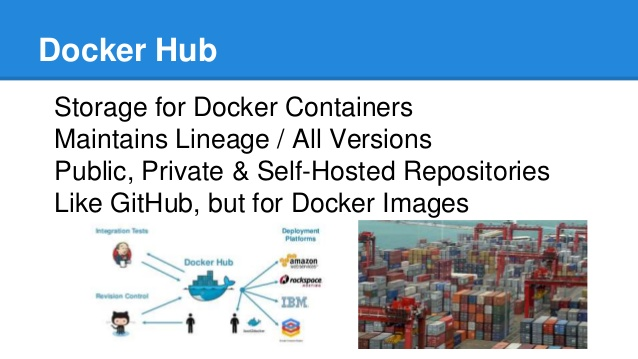

In [1]:
# Ignore this line: it is just to display the image below

curl -s 'http://image.slidesharecdn.com/dockerdemystifiedforsbjug-150918181554-lva1-app6892/95/docker-demystified-for-sb-jug-34-638.jpg' | display

As dockerlabs (dockerlabs AT mjbright.net) with the appropriate password (ask your instructor)

Once logged you should see the dockerlabs/toolset listed, otherwise you can search for it.

Click on the [dockerlabs/toolset](https://hub.docker.com/r/dockerlabs/toolset/) link, then on the [Tags](https://hub.docker.com/r/dockerlabs/toolset/tags/) link and you should now see your tagged image there.

#### Remove any running *'dockerlabs/toolset'* containers

We do this step to make sure we can easily delete your local dockerlabs/toolset:userN image.

These steps could be done by hand through use of 'docker ps' and 'docker ps -a' and picking containers ids corresponding to 'dockerlabs/toolset' containers to use with 'docker stop' and 'docker rm' commands.

The below expressions do this automatically for us.

In [122]:
IMAGE_NAME=dockerlabs/toolset

echo; echo "Currently running or stopped '$IMAGE_NAME' containers"
docker ps -a --filter=ancestor=$IMAGE_NAME

echo; echo "Stopping any running '$IMAGE_NAME' containers (so we can remove dockerlabs/ image)"
docker stop $(docker ps --filter=ancestor=$IMAGE_NAME) 2>/dev/null

echo; echo "Removing any stopped '$IMAGE_NAME' containers (so we can remove dockerlabs/ image)"
docker rm $(docker ps -a --filter=ancestor=$IMAGE_NAME) 2>/dev/null

echo; echo "There should be no more '$IMAGE_NAME' containers present:"
docker ps -a --filter=ancestor=$IMAGE_NAME


Currently running or stopped 'dockerlabs/toolset' containers
CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES

Stopping any running 'dockerlabs/toolset' containers (so we can remove dockerlabs/ image)

Removing any stopped 'dockerlabs/toolset' containers (so we can remove dockerlabs/ image)

There should be no more 'dockerlabs/toolset' containers present:
CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES


In [123]:
docker images dockerlabs/*

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
dockerlabs/toolset   userN               8f1514534590        33 hours ago        878.1 kB


In [124]:
docker rmi dockerlabs/toolset:userN

Untagged: dockerlabs/toolset:userN
Deleted: sha256:8f1514534590d210e849563568d477b2ec1571dfedcf1ccb0a7e36cc9c141ac2


In [125]:
docker images dockerlabs/*

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE


In [126]:
docker run dockerlabs/toolset:userN

Unable to find image 'dockerlabs/toolset:userN' locally
userN: Pulling from dockerlabs/toolset



Digest: sha256:8a2e3f3fae154e60e95adbbe95d4e67ada66c64adfbdbde4f5e56e8a56ac8a41
Status: Downloaded newer image for dockerlabs/toolset:userN
Hello World!!


In [127]:
docker images dockerlabs/*

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
dockerlabs/toolset   userN               a4d24d8a628e        20 hours ago        848.9 kB


In [128]:
docker run dockerlabs/toolset:userN /helloWorld.exe

Hello World!!


In [71]:
docker run dockerlabs/toolset:userN /hello


Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://docs.docker.com/userguide/



<a name="build-best-practices"/>
## Dockerfile best practices
[TOP](#TOP)

<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate certain Dockerfile optimizations.</b>
</font>

- group related commands together using '&&' to reduce image layers
- if temporary files are to be removed


In [72]:
cd ~/src/build-best-practices
cat Dockerfile


FROM ubuntu

MAINTAINER "Docker Labs" <dockerlabs@mjbright.net>

#
# Instead of perofmring the followinf commands individually which
# involves creating a separate image layer for each RUN command:
#   RUN apt-get update
#   RUN apt-get -y -q upgrade
#   RUN rm -rf /var/lib/apt/lists/*

# Here we combine the update, upgrade and cleanup steps into one command
# - This produces less image layers (better for disk space and performance)
# - This keeps image smaller by removing temporary files in the same layer
#     If we performed update/upgrade and then rm as a separate step there would
#     be an intermediate layer including those files, making the overall image larger.
#

RUN apt-get update && apt-get -y -q upgrade && rm -rf /var/lib/apt/lists/*



<a name="lang-stacks" />
## Using the official 'Language Stack' images
[TOP](#TOP)

<a name="medium-node" />
## Creating a Node.js application from the Node.js 'LanguageStack' Docker image
[TOP](#TOP)

Docker provide a set of *'Language Stacks'* which are medium sized images representing the necessary dependencies for a particular language.

<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate the use of Docker-provided *Language Stacks*.</b>
</font>

On the [Docker Hub](https://hub.docker.com/) we can find language stacks available for a variety of languages/environments, each with different release versions (Python 2.x and Python 3.x for example):
- [Node.js (Javascript)](https://hub.docker.com/_/node/)
- [Python](https://hub.docker.com/_/python/)
- [Ruby](https://hub.docker.com/_/ruby/)

You can browse the complete list of *'Official Images*' on the Docker Hub [here](https://hub.docker.com/explore/)

Now let's look at an example of Node.js.
To run a Node.js application this time we will need



In [73]:
time docker pull node

Using default tag: latest
latest: Pulling from library/node







Digest: sha256:1bdda7cdd0a8f9c44ac6f51c77de9f42ed3f62efdf557dba6bcca675084de1bd
Status: Image is up to date for node:latest

real	0m6.998s
user	0m0.034s
sys	0m0.009s


In [74]:
docker images node

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
node                latest              baa18fdeb577        7 days ago          643 MB


In [75]:
docker history node

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
baa18fdeb577        7 days ago          /bin/sh -c #(nop) CMD ["node"]                  0 B                 
<missing>           7 days ago          /bin/sh -c curl -SLO "https://nodejs.org/dist   36.39 MB            
<missing>           7 days ago          /bin/sh -c #(nop) ENV NODE_VERSION=5.5.0        0 B                 
<missing>           7 days ago          /bin/sh -c #(nop) ENV NPM_CONFIG_LOGLEVEL=inf   0 B                 
<missing>           7 days ago          /bin/sh -c set -ex   && for key in     9554F0   51.75 kB            
<missing>           8 days ago          /bin/sh -c apt-get update && apt-get install    314.6 MB            
<missing>           8 days ago          /bin/sh -c apt-get update && apt-get install    122.6 MB            
<missing>           8 days ago          /bin/sh -c apt-get update && apt-get install    44.28 MB            
<missing>   

In [76]:
cd ~/src/nodeJS/
ls -altr

total 12
drwxr-xr-x 2 root root  40 Feb  3 09:41 src
-rw-r--r-- 1 root root 116 Feb  3 09:41 README.md
-rw-r--r-- 1 root root 389 Feb  3 09:41 Dockerfile
-rw-r--r-- 1 root root  78 Feb  3 09:41 build_run.sh
drwxr-xr-x 9 root root 138 Feb  3 09:41 ..
drwxr-xr-x 3 root root  68 Feb  3 09:41 .


In [4]:
cat Dockerfile TODO !!!! edit file !!!

cat Dockerfile TODO echo $?echo $? edit file echo $?!
cat: Dockerfile: No such file or directory
cat: TODO: No such file or directory
cat: echo: No such file or directory
cat: 0echo: No such file or directory
cat: 0: No such file or directory
cat: edit: No such file or directory
cat: file: No such file or directory
cat: echo: No such file or directory
cat: 0!: No such file or directory


In [79]:
docker build -t node-hello .


Step 1 : FROM node
 ---> baa18fdeb577
Step 2 : ADD src/ /src
 ---> Using cache
 ---> ba5c0d52c61b
Step 3 : WORKDIR /src
 ---> Using cache
 ---> 243412a35ad4
Step 4 : RUN npm install
 ---> Using cache
 ---> 74bda417ede7
Step 5 : EXPOSE 80
 ---> Using cache
 ---> 44a4c1951ddf
Step 6 : CMD node index.js
 ---> Using cache
 ---> 98669ac8c83f
Successfully built 98669ac8c83f


In [80]:
docker run -p 80:80 --name web -d node-hello

ee8819187fd94524e6477398bde6bb0dadf5cd75af8e3a51004fd8990c89b631


In [81]:
curl http://localhost

<html><body>Hello from Node.js container ee8819187fd9</body></html>

<a name="medium-python"/>
## Creating a Python application from the Python 'LanguageStack' Docker image
[TOP](#TOP)

<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate the use of the Python *Language Stack*.</b>
</font>

Now let's look at a Python example.
To run a Node.js application this time we will need


Let's pull and examine the official 'Docker Language Stack' image of Python

Note how the earliest image layers (at the bottom of the list) have the same image ids
as the earliest image layers of the Node;js image.

So we can see that they were both created from the same base.

In [82]:
time docker pull python

Using default tag: latest
latest: Pulling from library/python








Digest: sha256:4651b83dd903ce78b1c455794f63d4108d9469a6c7fe97cd07d08a77b7e72435
Status: Image is up to date for python:latest

real	0m2.497s
user	0m0.030s
sys	0m0.011s


In [83]:
docker images python

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
python              latest              93049cc049a6        7 days ago          689.1 MB


In [85]:
docker history python

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
93049cc049a6        7 days ago          /bin/sh -c #(nop) CMD ["python3"]               0 B                 
<missing>           7 days ago          /bin/sh -c cd /usr/local/bin  && ln -s easy_i   0 B                 
<missing>           7 days ago          /bin/sh -c set -ex  && gpg --keyserver ha.poo   81.53 MB            
<missing>           7 days ago          /bin/sh -c #(nop) ENV PYTHON_PIP_VERSION=7.1.   0 B                 
<missing>           7 days ago          /bin/sh -c #(nop) ENV PYTHON_VERSION=3.5.1      0 B                 
<missing>           7 days ago          /bin/sh -c #(nop) ENV GPG_KEY=97FC712E4C024BB   0 B                 
<missing>           7 days ago          /bin/sh -c #(nop) ENV LANG=C.UTF-8              0 B                 
<missing>           7 days ago          /bin/sh -c apt-get purge -y python.*            978.7 kB            
<missing>   

In [128]:
docker run python python --version

Python 3.5.1


In [130]:
cd ~/src/python_flask
cat Dockerfile

FROM python:2.7

MAINTAINER "Docker Build Lab" <dockerlab@mjbright.net>

WORKDIR /src

ADD requirements.txt /src/

RUN pip install -r requirements.txt

ADD . /src

CMD python flask_redis_app.py



In [134]:
docker build -t lab/python_flask .



Step 1 : FROM python:2.7
2.7: Pulling from library/python








Digest: sha256:84d75f33b4ae12997a0a2d51481ed18525ee7b49a5660c3301a00dfb2db19a14
Status: Downloaded newer image for python:2.7
 ---> 31093b2dabe2
Step 2 : MAINTAINER "Docker Build Lab" <dockerlab@mjbright.net>
 ---> Running in fa6f37644a0d
 ---> baf5e793c7e5
Removing intermediate container fa6f37644a0d
Step 3 : WORKDIR /src
 ---> Running in b958687fa4dd
 ---> 27c199001060
Removing intermediate container b958687fa4dd
Step 4 : ADD requirements.txt /src/
 ---> 7ea28cc9002d
Removing intermediate container 14db71be2517
Step 5 : RUN pip install -r requirements.txt
 ---> Running in 85f835fbc058
  Running setup.py bdist_wheel for flask
  Stored in directory: /root/.cache/pip/wheels/d2/db/61/cb9b80526b8f3ba89248ec0a29d6da1bb6013681c930fca987
  Running setup.py bdist_wheel for itsdangerous
  Stored in directory: /root/.cache/pip/wheels/97/c0/b8/b37c320ff57e15f993ba0ac98013eee778920b4a7b3ebae3cf
  Running setup.py bdist_wheel for M

In [135]:
docker images lab/*

REPOSITORY          TAG                 IMAGE ID            CREATED              SIZE
lab/python_flask    latest              c261953c57b7        About a minute ago   682.8 MB
lab/basic           latest              30f6d0c187c3        4 hours ago          689.1 MB
lab/toolset         latest              eb7cbf013c9a        4 hours ago          848.9 kB
lab/go-hello        latest              d7e7f28bac89        4 hours ago          2.367 MB
lab/go-web          latest              d7e7f28bac89        4 hours ago          2.367 MB
lab/c_prog          latest              cc40573ce67a        4 hours ago          848 kB


In [ ]:
docker run lab/python_flask

In [ ]:
curl http://localhost:5000

  <a name="Compose" />
#   Using Compose
<a href="#TOP">TOP</a>
  
#   Building complex systems with Compose
<a href="#TOP">TOP</a>

In [107]:
cd ~/src/compose

cat docker-compose.yml


version: 2
services:
  weba:
    build: ../nodeJS
    expose:
      - 80

  webb:
    build: ../nodeJS
    expose:
      - 80

  webc:
    build: ../nodeJS
    expose:
      - 80

  haproxy:
    image: haproxy
    volumes:
     - ./haproxy:/haproxy-override
    links:
     - weba
     - webb
     - webc
    ports:
     - "80:80"
     - "70:70"

    expose:
     - "80"
     - "70"




In [115]:
docker-compose

Define and run multi-container applications with Docker.

Usage:
  docker-compose [-f=<arg>...] [options] [COMMAND] [ARGS...]
  docker-compose -h|--help

Options:
  -f, --file FILE           Specify an alternate compose file (default: docker-compose.yml)
  -p, --project-name NAME   Specify an alternate project name (default: directory name)
  --verbose                 Show more output
  -v, --version             Print version and exit

Commands:
  build              Build or rebuild services
  config             Validate and view the compose file
  create             Create services
  down               Stop and remove containers, networks, images, and volumes
  events             Receive real time events from containers
  help               Get help on a command
  kill               Kill containers
  logs               View output from containers
  pause              Pause services
  port               Print the public port for a port binding
  ps                 List containers
  pul

In [118]:
docker-compose stop

In [119]:
docker-compose rm -f

Going to remove compose_haproxy_1, compose_weba_1, compose_webc_1, compose_webb_1






In [120]:
docker-compose up -d

Creating compose_webb_1
Creating compose_webc_1
Creating compose_weba_1
Creating compose_haproxy_1
ERROR: failed to create endpoint compose_haproxy_1 on network compose_default: Bind for 0.0.0.0:80 failed: port is already allocated


```bash
docker-compose logs
Attaching to compose_haproxy_1, compose_weba_1, compose_webc_1, compose_webb_1
haproxy_1 | [ALERT] 032/221525 (1) : Could not open configuration file /usr/local/etc/haproxy/haproxy.cfg : No such file or directory
haproxy_1 | [ALERT] 032/221646 (1) : Could not open configuration file /usr/local/etc/haproxy/haproxy.cfg : No such file or directory
weba_1    | Running on http://localhost
webc_1    | Running on http://localhost
webb_1    | Running on http://localhost
```

In [121]:
docker-compose ps

      Name                     Command                State     Ports  
----------------------------------------------------------------------
compose_haproxy_1   haproxy -f /usr/local/etc/ ...   Exit 128          
compose_weba_1      node index.js                    Up         80/tcp 
compose_webb_1      node index.js                    Up         80/tcp 
compose_webc_1      node index.js                    Up         80/tcp 


In [122]:
docker-compose scale weba=5

In [123]:
docker-compose ps

      Name                     Command                State     Ports  
----------------------------------------------------------------------
compose_haproxy_1   haproxy -f /usr/local/etc/ ...   Exit 128          
compose_weba_1      node index.js                    Up         80/tcp 
compose_weba_2      node index.js                    Up         80/tcp 
compose_weba_3      node index.js                    Up         80/tcp 
compose_weba_4      node index.js                    Up         80/tcp 
compose_weba_5      node index.js                    Up         80/tcp 
compose_webb_1      node index.js                    Up         80/tcp 
compose_webc_1      node index.js                    Up         80/tcp 


In [124]:
docker-compose up --force-recreate -d

Recreating compose_webb_1
Recreating compose_webc_1
Recreating compose_weba_2
ERROR: 
Aborting.


In [ ]:
# TODO:
docker-compose events

In [125]:
docker-compose ps

      Name                     Command                State     Ports  
----------------------------------------------------------------------
compose_haproxy_1   haproxy -f /usr/local/etc/ ...   Exit 128          
compose_weba_1      node index.js                    Up         80/tcp 
compose_weba_2      node index.js                    Exit 137          
compose_weba_3      node index.js                    Up         80/tcp 
compose_weba_4      node index.js                    Up         80/tcp 
compose_weba_5      node index.js                    Up         80/tcp 
compose_webb_1      node index.js                    Up         80/tcp 
compose_webc_1      node index.js                    Up         80/tcp 


In [ ]:
#docker-compose logs

In [ ]:
# docker-compose up
# docker-compose down
# TODO: Add heterogeneous example ...

TODO: extend to heterogeneous cases ...


# Rails Example with Compose
<a href="#TOP">TOP</a>

This example heavily inspired from this article [Building Microservices with Docker and the Rails API gem](https://medium.com/connect-the-dots/building-microservices-with-docker-and-the-rails-api-gem-2a463862f5d)

<font size=+1 color="#77f">
<b>The goal of this step is to have hands-on experience with Compose ...</b> 
<br/>
It is recommended to use [yamllint](http://www.yamllint.com/) to validate your YAML file - because it's easy to make mistakes in YAML, and Compose is picky.
</font>

In [36]:
cd /root
mkdir -p src/railsapi
cd src/railsapi
pwd
touch Dockerfile docker-compose.yml Gemfile Gemfile.lock

/root/src/railsapi


In [37]:
cat > Dockerfile <<EOF

FROM ruby:2.3.0

RUN apt-get update -qq && apt-get install -y build-essential libmysqlclient-dev

RUN mkdir /railsapi

WORKDIR /railsapi

ADD Gemfile /railsapi/Gemfile

ADD Gemfile.lock /railsapi/Gemfile.lock

RUN bundle install

ADD . /railsapi

EOF


See [References](#References) section below for information on *Compose*



In [38]:
cat > docker-compose.yml <<EOF

version: 2
services:
  db:
   image: mysql:latest
   ports:
     - 3306:3306
   environment:
     MYSQL_ROOT_PASSWORD: mypassword
   
  web:
    build: .
    command: puma
    ports:
      - 9292:9292
    links:
      - db
    volumes:
      - .:/railsapi

EOF

In [39]:
docker-compose build

db uses an image, skipping
Building web
Step 1 : FROM ruby:2.3.0
 ---> 70578fbdd1a4
Step 2 : RUN apt-get update -qq && apt-get install -y build-essential libmysqlclient-dev
 ---> Using cache
 ---> 542437588210
Step 3 : RUN mkdir /railsapi
 ---> Using cache
 ---> 458b06826730
Step 4 : WORKDIR /railsapi
 ---> Using cache
 ---> 972ec34e499e
Step 5 : ADD Gemfile /railsapi/Gemfile
 ---> Using cache
 ---> 60947231435f
Step 6 : ADD Gemfile.lock /railsapi/Gemfile.lock
 ---> 53c629b24a97
Removing intermediate container 1aac5f737465
Step 7 : RUN bundle install
 ---> Running in c7e1111ea35d
Fetching gem metadata from https://rubygems.org/...........
Fetching version metadata from https://rubygems.org/...
Fetching dependency metadata from https://rubygems.org/..
Installing rake 10.5.0
Installing i18n 0.7.0
Using json 1.8.3
Installing minitest 5.8.4
Installing thread_safe 0.3.5
Installing builder 3.2.2
Installing erubis 2.7.0
Installing mini_portile2 2.0.0
Installing rack 1.6.4
Installing mime-type

In [40]:
cat > Gemfile <<EOF

source 'https://rubygems.org'

gem 'rails', '4.2.5'
gem 'rails-api', '0.4.0'
gem 'mysql2'
gem 'puma'

# Use ActiveModel has_secure_password
# gem 'bcrypt', '~> 3.1.7'

# Use Capistrano for deployment
# gem 'capistrano-rails', group: :development

# Use Rack CORS for handling Cross-Origin Resource Sharing (CORS), making cross-origin AJAX possible
# gem 'rack-cors'

# Use ActiveModelSerializers to serialize JSON responses
gem 'active_model_serializers', '~> 0.10.0.rc3'

group :development, :test do
  # Call 'byebug' anywhere in the code to stop execution and get a debugger console
  gem 'byebug'
end
 
group :development do # Spring speeds up development by keeping your application running in the background. Read more: https://github.com/rails/spring
  gem 'spring'
end

EOF

In [41]:
ls -altr

total 32
-rw-r--r-- 1 root root  478 Jan 31 19:34 README.rdoc
-rw-r--r-- 1 root root  249 Jan 31 19:34 Rakefile
-rw-r--r-- 1 root root  474 Jan 31 19:34 .gitignore
-rw-r--r-- 1 root root  153 Jan 31 19:34 config.ru
drwxr-xr-x 2 root root  147 Jan 31 19:34 .
drwxr-xr-x 4 root root   34 Jan 31 19:45 ..
-rw-r--r-- 1 root root 2928 Jan 31 20:01 Gemfile.lock
-rw-r--r-- 1 root root  248 Jan 31 20:01 Dockerfile
-rw-r--r-- 1 root root  258 Jan 31 20:02 docker-compose.yml
-rw-r--r-- 1 root root  779 Jan 31 20:10 Gemfile


Now let's build our image

In [42]:
docker-compose build

db uses an image, skipping
Building web
Step 1 : FROM ruby:2.3.0
 ---> 70578fbdd1a4
Step 2 : RUN apt-get update -qq && apt-get install -y build-essential libmysqlclient-dev
 ---> Using cache
 ---> 542437588210
Step 3 : RUN mkdir /railsapi
 ---> Using cache
 ---> 458b06826730
Step 4 : WORKDIR /railsapi
 ---> Using cache
 ---> 972ec34e499e
Step 5 : ADD Gemfile /railsapi/Gemfile
 ---> Using cache
 ---> 60947231435f
Step 6 : ADD Gemfile.lock /railsapi/Gemfile.lock
 ---> Using cache
 ---> 53c629b24a97
Step 7 : RUN bundle install
 ---> Using cache
 ---> 2611f8731623
Step 8 : ADD . /railsapi
 ---> Using cache
 ---> 7159710bbffe
Successfully built 7159710bbffe


In [43]:
docker images

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
railsapi_web        latest              7159710bbffe        6 minutes ago       813.8 MB
lab/basic           latest              5477a1cdda04        11 minutes ago      689.1 MB
<none>              <none>              a192650246e9        11 minutes ago      689.1 MB
<none>              <none>              a7d63cd9ba3c        12 minutes ago      689.1 MB
<none>              <none>              8855922a993d        46 minutes ago      813.8 MB
<none>              <none>              bef232158200        48 minutes ago      746.3 MB
rails_web           latest              5152cec9abc7        53 minutes ago      813.8 MB
<none>              <none>              349e9cce0641        About an hour ago   813.8 MB
<none>              <none>              96b443625f76        About an hour ago   813.8 MB
<none>              <none>              7d9bce362118        About an hour ago   813.8 MB
<none>              <none

In [44]:
docker-compose run web rails-api new .

       exist  
   identical  README.rdoc
   identical  Rakefile
   identical  config.ru
   identical  .gitignore
    conflict  Gemfile
Overwrite /railsapi/Gemfile? (enter "h" for help) [Ynaqdh] 


In [46]:
cat > database.yml <<EOF
development:
 adapter: mysql2
 encoding: utf8
 reconnect: false
 database: inventory_manager_dev
 pool: 5
 username: root
 password: mypassword
 host: db
test:
 adapter: mysql2
 encoding: utf8
 reconnect: false
 database: inventory_manager_test
 pool: 5
 username: root
 password: mypassword
 host: db
EOF

In [48]:
docker-compose up web

railsapi_db_1 is up-to-date
Creating railsapi_web_1
Attaching to railsapi_web_1
web_1 | Puma starting in single mode...
web_1 | * Version 2.16.0 (ruby 2.3.0-p0), codename: Midwinter Nights Trance
web_1 | * Min threads: 0, max threads: 16
web_1 | * Environment: development
web_1 | config.ru:3:in `require': cannot load such file -- /railsapi/config/environment (LoadError)
web_1 | 	from config.ru:3:in `block in <main>'
web_1 | 	from /usr/local/bundle/gems/rack-1.6.4/lib/rack/builder.rb:55:in `instance_eval'
web_1 | 	from /usr/local/bundle/gems/rack-1.6.4/lib/rack/builder.rb:55:in `initialize'
web_1 | 	from config.ru:in `new'
web_1 | 	from config.ru:in `<main>'
web_1 | 	from /usr/local/bundle/gems/rack-1.6.4/lib/rack/builder.rb:49:in `eval'
web_1 | 	from /usr/local/bundle/gems/rack-1.6.4/lib/rack/builder.rb:49:in `new_from_string'
web_1 | 	from /usr/local/bundle/gems/rack-1.6.4/lib/rack/builder.rb:40:in `parse_file'
web_1 | 	from /usr/local/bundle/gems/puma-2.16.0/lib/puma/configuration.rb

In [49]:
curl http://localhost:80

curl: (7) Failed to connect to localhost port 80: Connection refused


<a name="building-docker" />
# Building Docker with Docker
<a href="#TOP">TOP</a>

<a name="Building-Docker-with-Docker" />
# Building Docker with Docker
<a href="#TOP">TOP</a>

A major advantage of Docker is to simplify build environments.

Let's look at how we can build the Docker engine client/daemon binary without having to explicitly install a development environment.

<font size=+1 color="#77f">
<b>The goal of this step is simply to show the ease with which we can build Docker, thanks to Docker itself.</b>   
</font>

We do not make particular use of the built image.

The process involves the following steps, several of which have already been performed so as to prevent excessive network utilisation during the lab.  Nevertheless all steps are  described here so that you can see just how easy it is to build Docker from scratch:
- Install make
- Clone the Docker source code
- Checkout the same code revision as our current Docker binary (client and daemon)
- Build the code - which pulls the docker-dev image containing the required version of the Go compiler
- Run the executable to demonstrate it is correct

#### Installing make

In your environment we have already installed the make package, but no compiler using yum:

    yum install make

#### Cloning the Docker source code

We have already downloaded the Docker source code from github as follows:

    mkdir -p /root/src/docker
    cd /root/src/docker
    git clone https://github.com/docker/docker .

To build Docker we simply have to build using the

    make build
    
command.

#### Checkout the source code revision corresponding to our installed Docker Engine

If we build the latest sources this may not be compatible with our installed Docker version.

This is the case.  We have 1.10.0-rc2 installed, which has API version 22, but the current github source is 1.10.0-dev which has changed to API version 23.  So if we build this we find that we cannot use this client to communicate with the installed daemon.

So let's checkout the code for 1.10.0-rc2.

At the time of writing this is the latest release(candidate) of the Docker engine.
We can obtain that version of the source code by referring to the releases page https://github.com/docker/docker/releases
and selecting the SHA1 hash of build 1.10.0-rc2 

    git checkout c1cdc6e



#### Build the code - which pulls the docker-dev image containing the required version of the Go compiler

We can build the code as follows:

    make build
    
We have run 'make build' already, so the docker-dev image has already been downloaded (again to prevent excessive network traffic).  The docker-dev image includes the required go compiler and other build tools.

Run 'make build' again and you will see a standard build process and finally where it places the compiled binary

#### Run the executable to demonstrate it is correct

In preparation for the lab we built from the latest source (not the c1cdc6e version we checked out).

Run this build as follows to see that it is not compatible with the installed binary (/usr/bin/docker).
We see that this binary has version 1.10.0-dev and API version 1.23 but that this cannot communicate with our installed binary which has API version 1.22.

In [ ]:
cd /root/src/docker; ls -altr bundles/1.10.0-dev/binary/docker-1.10.0-dev; ./bundles/1.10.0-dev/binary/docker version

But if we run our new build - as follows - created from revision c1cdc6e of the source code (corresponding to Docker version 1.10.0-rc2) we see that it has the correct version, with the same API version and can interrogate the server.


In [ ]:
cd /root/src/docker; ls -altr bundles/1.10.0-rc2/binary/docker-1.10.0-rc2; ./bundles/1.10.0-rc2/binary/docker version

# References
[TOP](#TOP)

- [Dockerfile Reference](https://docs.docker.com/engine/reference/builder/)

- [Compose file documentation](https://docs.docker.com/compose/compose-file/)

- [Compose file reference](https://github.com/docker/compose/blob/1.6.0-rc1/docs/compose-file.md)

- [Visualizing Docker Containers and Images](http://merrigrove.blogspot.in/2015/10/visualizing-docker-containers-and-images.html)

- [Awesome Docker](https://github.com/veggiemonk/awesome-docker)

- [Docker Cheat Sheet]()

- [Building Good Docker Images](http://jonathan.bergknoff.com/journal/building-good-docker-images)

- [How to scale a Docker Container with Docker Compose](https://www.brianchristner.io/how-to-scale-a-docker-container-with-docker-compose/)

- [Docker Compose Demo](https://github.com/vegasbrianc/docker-compose-demo)
